这个记事本是用来搭建CRNN网络的，用来做recognition

In [1]:
import os
import torch
from torch import nn
from torchvision import models
from utils import *
from matplotlib import pyplot as plt
import numpy as np
from torch.utils import tensorboard as tb

dataset_IAM = RecDataset("IAM", "train")
dataset_CVL = RecDataset("CVL", "train")
dataset = torch.utils.data.ConcatDataset([dataset_IAM, dataset_CVL])
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=16)

/root/autodl-tmp/APS360_Project/Train/utils.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(os.path.join(self.path, 'rec_data_' + mode + '.pt'))


In [2]:
# 测试用的代码，不用看
model = models.resnet50(pretrained=True)
# model_cnn = nn.Sequential(*list(model.children())[:-1])
for chi in model.children():
    print(chi)
    print('-------------------')

/root/miniconda3/envs/new_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/new_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-------------------
ReLU(inplace=True)
-------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-------------------
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

这里用resnet18除去最后的fc作为cnn的部分，lstm作为rnn的部分。<br>
输入1x128x128图片<br>
经过cnn部分，先是卷到了512x4x4，然后经过平均池化层变成512x1x1<br>
然后展平，经过线性变换放入lstm的hidden和cell

In [8]:
class CRNN(nn.Module):
    """
    这是一个基于CNN和LSTM的CRNN模型，用于生成文本

    """
    def __init__(self, num_classes=128, hidden_dim=512, io_dim=1024, device='cuda:0'):
        super(CRNN, self).__init__()
        # num-classes对应ascii码表的128种字符
        self.num_classes = num_classes
        # hidden_dim是LSTM的隐藏层（hidden state）和细胞状态（cell state）的维度
        self.hidden_dim = hidden_dim
        # io_dim是LSTM的输入和输出的维度
        self.io_dim = io_dim
        self.device = device
        # max num of characters of the generated text
        self.max_len = 64
        # 1x1卷积层，用于将灰度图转换为3通道图像以适应ResNet的输入
        self.conv1 = nn.Conv2d(1, 3, 1)
        # 使用ResNet50作为CNN的基础模型，去掉最后一层全连接层
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output dim is 2048
        # LSTM层，输入维度为io_dim，隐藏层维度为hidden_dim
        self.rnn = nn.LSTM(io_dim, hidden_dim, 1, batch_first=True)
        # 将CNN的输出转换为LSTM的隐藏状态和细胞状态
        self.h0_fc = nn.Linear(2048, hidden_dim)
        self.c0_fc = nn.Linear(2048, hidden_dim)
        # 将LSTM的输出转换为最终的输出，即字符概率分布
        self.out_fc = nn.Linear(hidden_dim, num_classes)
        # 将字符的索引转换为字符的embedding
        self.embedding = nn.Embedding(num_classes, io_dim)
        # dropout防止过拟合
        self.dropout = nn.Dropout(0.5)
        self.to(device)
    
    def init_state(self, img):
        # 通过CNN卷出 lstm 的 hidden state 和 cell state
        x = self.conv1(img)         # batch_size, 3, 64, 64
        x = self.cnn(x)             # batch_size, 512, 1, 1
        x = x.view(x.size(0), -1)   # batch_size, 512
        x = x.unsqueeze(0)          # 1, batch_size, 512
        h0 = self.h0_fc(x)          # 1, batch_size, hidden_dim
        c0 = self.c0_fc(x)          # 1, batch_size, hidden_dim
        return h0, c0
    
    def next_char(self, x, h_c_n):
        # print("next char x shape: ", x.shape)
        h_n, c_n = h_c_n
        # x: the embedding of the last character
        # h_n: the hidden state of the last character
        # c_n: the cell state of the last character
        x, (h_n, c_n) = self.rnn(x, (h_n, c_n))
        # print("next char rnn output x shape: ", x.shape)
        x = self.out_fc(x)
        x = self.dropout(x)
        # print("next char output x shape: ", x.shape)
        return x, (h_n, c_n)
    
    def forward(self, img):
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        # print("after embedding x shape: ", x.shape)
        h_c_n = (h0, c0)
        temp = torch.zeros(batch_size, 1, self.num_classes).to(self.device)
        temp[:, 0, 2] = 1
        output = [temp]
        for i in range(1, self.max_len):
            x, h_c_n = self.next_char(x, h_c_n)
            output.append(x)
            x = x.argmax(dim=-1)
            x = self.embedding(x)
        output = torch.cat(output, dim=1)
        return output

In [9]:
# 测试CRNN进行预测时的形状是否符合要求

crnn = CRNN()
for step, (img, label) in enumerate(dataloader):
    img, label = img.to(crnn.device), label.to(crnn.device)
    print(img.shape)
    output = crnn(img)
    print(output.shape)
    break

torch.Size([64, 1, 128, 128])
torch.Size([64, 64, 128])


In [10]:
# 测试CRNN进行训练时的形状是否符合要求

crnn = CRNN()
for step, (img, label) in enumerate(dataloader):
    img, label = img.to(crnn.device), label.to(crnn.device)
    print(img.shape)
    h_n, c_n = crnn.init_state(img)
    print(h_n.shape, c_n.shape)
    break

torch.Size([64, 1, 128, 128])
torch.Size([1, 64, 512]) torch.Size([1, 64, 512])


In [11]:
# 可能要调的超参数有：hidden_dim, io_dim, lr, batch_size, num_epochs, dataset_name
def get_model_name(hidden_dim, io_dim, lr, batch_size, num_epochs, dataset_name):
    return f"crnn_{hidden_dim}_{io_dim}_{lr}_{batch_size}_{num_epochs}_{dataset_name}.pth"


def get_val_loss(model, dataloader, device):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    loss = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss += criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
    return loss / len(dataloader)


# 下面是训练的代码，使用教师强制训练
def train_crnn(model, dataloader, learning_rate, epochs, device, start_epoch=0):

    # 如果start_epoch不为0，说明是从某个epoch开始训练的，需要加载模型
    if start_epoch:
        model_name = get_model_name(model.hidden_dim, model.io_dim, learning_rate, dataloader.batch_size, start_epoch, "concat")
        model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
        model.load_state_dict(torch.load(model_path + model_name))
        start_epoch += 1
        print(f"Model loaded from {model_name}")

    writer = tb.SummaryWriter('/root/tf-logs')
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    model.to(device)
    for epoch in range(start_epoch, epochs):
        model.train()
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            loss = 0
            # 准备初始状态
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss = criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
            # mask = (target.argmax(-1) != 0).view(-1)
            # loss = loss[mask].mean()
            loss.backward()
            # 将cnn的参数乘0.1
            for param in model.cnn.parameters():
                param.grad *= 0.1
            optimizer.step()
            if step % 100 == 0:
                print(f"Epoch {epoch}, Iter {step}, Loss {loss.item()}")
                writer.add_scalar('CRNN_Loss', loss.item(), epoch * len(dataloader) + step)
        
        # 计算验证集上的loss
        val_loss = get_val_loss(model, val_dataloader, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch}, Val Loss {val_loss.item()}")
        writer.add_scalar('CRNN_Val_Loss', val_loss.item(), epoch)

        model_name = get_model_name(model.hidden_dim, model.io_dim, learning_rate, dataloader.batch_size, epoch, "concat")
        model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
        torch.save(model.state_dict(), model_path + model_name)
        print(f"Model saved as {model_name}")


model = CRNN()
# model_name = get_model_name(model.hidden_dim, model.io_dim, 0.001, 64, 84, "IAM")
model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
# model.load_state_dict(torch.load(model_path + model_name))
# dataset = RecDataset("CVL", "train")
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
val_dataset_IAM = RecDataset("IAM", "val")
val_dataset_CVL = RecDataset("CVL", "val")
val_dataset = torch.utils.data.ConcatDataset([val_dataset_IAM, val_dataset_CVL])
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=16)
dataset_IAM = RecDataset("IAM", "train")
dataset_CVL = RecDataset("CVL", "train")
dataset = torch.utils.data.ConcatDataset([dataset_IAM, dataset_CVL])
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16)
train_crnn(model, dataloader, 0.01, 500, "cuda:0", 43)

/root/autodl-tmp/APS360_Project/Train/utils.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(os.path.join(self.path, 'rec_data_' + mode + '.pt'))


Model loaded from crnn_512_1024_0.01_64_43_concat.pth


/tmp/ipykernel_1879/1949177352.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path + model_name))
/root/miniconda3/envs/new_env/

Epoch 44, Iter 0, Loss 10.462600708007812
Epoch 44, Iter 100, Loss 2.7052228450775146
Epoch 44, Iter 200, Loss 2.5797746181488037
Epoch 44, Iter 300, Loss 2.561100482940674
Epoch 44, Iter 400, Loss 2.42060923576355
Epoch 44, Iter 500, Loss 2.5613961219787598
Epoch 44, Iter 600, Loss 2.4989161491394043
Epoch 44, Iter 700, Loss 2.5583102703094482
Epoch 44, Iter 800, Loss 2.4603042602539062
Epoch 44, Iter 900, Loss 2.472644090652466
Epoch 44, Iter 1000, Loss 2.4352757930755615
Epoch 44, Iter 1100, Loss 2.4676551818847656
Epoch 44, Iter 1200, Loss 2.5000548362731934
Epoch 44, Iter 1300, Loss 2.581332206726074
Epoch 44, Iter 1400, Loss 2.488685131072998
Epoch 44, Iter 1500, Loss 2.535407304763794
Epoch 44, Iter 1600, Loss 2.4326534271240234
Epoch 44, Iter 1700, Loss 2.5917747020721436
Epoch 44, Iter 1800, Loss 2.5547568798065186
Epoch 44, Iter 1900, Loss 2.4932193756103516
Epoch 44, Iter 2000, Loss 2.342564105987549
Epoch 44, Iter 2100, Loss 2.5863428115844727
Epoch 44, Iter 2200, Loss 2.52

In [ ]:
# load model
model = CRNN()
model_name = get_model_name(512, 1024, 0.01, 64, 33, "concat")
model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name))
model.to("cuda:0")
model.eval()

def show_img(img):
    img = img.squeeze().cpu().numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

def get_word(output):
    output = output.cpu().detach().numpy()
    word = ""
    for i in range(1, 64):
        o = np.argmax(output[i])
        if o == 3:
            break
        c = chr(o)
        word += c
    return word

# test
dataset = RecDataset("IAM", "val")
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

predict: ,
answer:  '


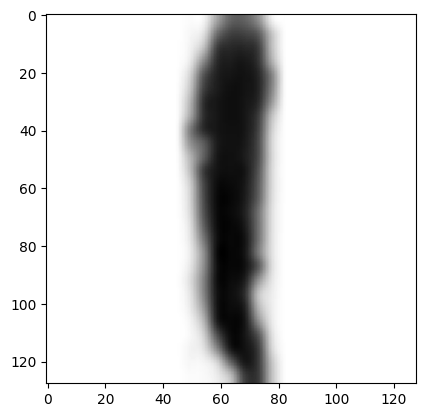

In [ ]:
for step, (img, label) in enumerate(dataloader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    output = model(img)
    print("predict:", get_word(output[0]))
    print("answer: ", get_word(label[0]))
    show_img(img[0])
    plt.show()
    break

In [ ]:
# plot loss crv

model = CRNN().cuda()
train_loader = DataLoader(RecDataset("IAM", "train"), batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(RecDataset("IAM", "val"), batch_size=64, shuffle=True, num_workers=8)
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss(ignore_index=0)
device = "cuda:0"

for epoch in range(76):
    model_name = get_model_name(512, 1024, 0.01, 64, epoch, "concat")
    model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
    model.load_state_dict(torch.load(model_path + model_name))
    model.eval()
    loss = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(val_loader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss += criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
    val_losses.append(loss / len(dataloader))
    print(f"Epoch {epoch}, Val Loss {val_losses[-1]}")

Epoch 0, Val Loss 0.23437054455280304


KeyboardInterrupt: 

In [ ]:
for epoch in range(90):
    model_name = get_model_name(model.hidden_dim, model.io_dim, 0.001, 64, epoch, "IAM")
    model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
    model.load_state_dict(torch.load(model_path + model_name))
    model.eval()
    loss = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss += criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
    train_losses.append(loss / len(dataloader))
    print(f"Epoch {epoch}, Val Loss {train_losses[-1]}")

Epoch 0, Val Loss 3.478210210800171
Epoch 1, Val Loss 3.0621519088745117
Epoch 2, Val Loss 2.8425073623657227
Epoch 3, Val Loss 2.685619592666626
Epoch 4, Val Loss 2.55229115486145
Epoch 5, Val Loss 2.4177439212799072
Epoch 6, Val Loss 2.3057734966278076
Epoch 7, Val Loss 2.2105913162231445
Epoch 8, Val Loss 2.111955165863037
Epoch 9, Val Loss 2.030163049697876
Epoch 10, Val Loss 1.9540117979049683
Epoch 11, Val Loss 1.8829811811447144
Epoch 12, Val Loss 1.8394535779953003
Epoch 13, Val Loss 1.757978081703186
Epoch 14, Val Loss 1.7055529356002808
Epoch 15, Val Loss 1.6645315885543823
Epoch 16, Val Loss 1.606818437576294
Epoch 17, Val Loss 1.5785996913909912
Epoch 18, Val Loss 1.584167242050171
Epoch 19, Val Loss 1.4771547317504883
Epoch 20, Val Loss 1.4356818199157715
Epoch 21, Val Loss 1.4132806062698364
Epoch 22, Val Loss 1.370862364768982
Epoch 23, Val Loss 1.3342267274856567
Epoch 24, Val Loss 1.3297675848007202
Epoch 25, Val Loss 1.282596230506897
Epoch 26, Val Loss 1.263351440429

In [ ]:
# fix bug
val_temp = [i.item() for i in val_losses]
train_temp = [i.item() for i in train_losses]
dataset_len = len(dataloader)
val_len = len(val_loader)
train_len = len(train_loader)
val_temp = [i / val_len * dataset_len for i in val_temp]
train_temp = [i / train_len * dataset_len for i in train_temp]
print(val_temp)
print(train_temp)

[]
[]


In [ ]:
import pickle
with open("train_losses.pkl", "wb") as f:
    pickle.dump(train_losses, f)
with open("val_losses.pkl", "wb") as f:
    pickle.dump(val_losses, f)

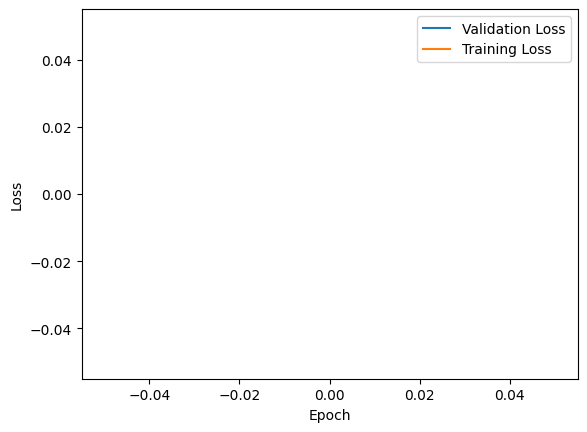

In [ ]:
plt.plot(val_temp)
plt.plot(train_temp)
plt.legend(["Validation Loss", "Training Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()